In [3]:
import tensorflow
import numpy as np
from pyscf import gto, scf, mp, lo
from pyscf.tools import cubegen
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.spatial.distance import cdist

In [2]:
data = np.load("../../data/md17_benzene2017.npz", allow_pickle=True)
R = data["R"][2].tolist()
Z = data["z"]

FileNotFoundError: [Errno 2] No such file or directory: '../../data/md17_benzene2017.npz'

In [ ]:
mol = gto.Mole()
atom_data = list(zip(Z, R))
mol.atom = atom_data
mol.basis = "ccpvdz"
mol.build()

: 

In [ ]:
hf_result = scf.HF(mol).run()
hf_1dm = hf_result.make_rdm1()
hf_2dm = hf_result.make_rdm2()
time1 = datetime.datetime.now()

hf_atomic_orbitals = mol.intor("int1e_ovlp")
mo_coeff = hf_result.mo_coeff
hf_energy = hf_result.e_tot
hf_atomic_orbitals.shape

: 

In [ ]:
fig_ao = plt.figure(figsize=(6,6))
ax_ao = fig_ao.add_subplot(111)
ax_ao.set_title("Atomic orbital overlap")
image_ao = ax_ao.imshow(hf_atomic_orbitals)
plt.colorbar(image_ao)
plt.show()

: 

In [ ]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.set_title('DM_HF')
image = ax.imshow(hf_1dm)
plt.colorbar(image)
plt.show()

: 

**Fourier transform of HF_DM**

In [ ]:
hf_dm_fft = np.abs(np.fft.fft2(hf_1dm))

: 

In [ ]:
fig_fft = plt.figure(figsize=(6, 6))
ax_fft = fig_fft.add_subplot(111)
ax_fft.set_title('DM_HF_FFT')
image_fft = ax_fft.imshow(hf_dm_fft)
plt.colorbar(image_fft)
plt.show()

: 

In [ ]:
hf_h_ij = mol.intor("int1e_nuc") + mol.intor("int1e_kin")
hf_h_ijkl = mol.intor("int2e")
hf_energy_core = np.einsum("pq,qp", hf_h_ij, hf_1dm)
hf_energy_elec = hf_energy_core + 0.5 * np.einsum("pqrs,pqrs", hf_h_ijkl, hf_2dm)
hf_guessed_energy = hf_energy_elec + mol.energy_nuc()

: 

In [ ]:
print(f"Correct HF energy: {hf_energy}")
print(f"Guessed HF energy: {hf_guessed_energy}")
print(f"Guessed HF core energy: {hf_energy_core}")

: 

**Moller Plesset Perturbation theory**

In [ ]:
mp2_result = mp.MP2(hf_result).run()
mp2_1dm = mp2_result.make_rdm1(ao_repr=True)
#mp2_2dm = mp2_result.make_rdm2(ao_repr=True)
mp2_energy = mp2_result.e_tot

: 

In [ ]:
fig_mp2 = plt.figure(figsize=(6, 6))
ax_mp2 = fig_mp2.add_subplot(111)
ax_mp2.set_title('P_ij PHF')
image_mp2 = ax_mp2.imshow(mp2_1dm)
plt.colorbar(image_mp2)
plt.imshow(mp2_1dm)

: 

In [ ]:
fig_diff = plt.figure(figsize=(6, 6))
ax_diff = fig_diff.add_subplot(111)
ax_diff.set_title('DM_HF - DM_MP2')
image_diff = ax_diff.imshow(hf_1dm - mp2_1dm)
plt.colorbar(image_diff)
plt.show()

: 

In [ ]:
mp2_h_ij = mol.intor("int1e_nuc") + mol.intor("int1e_kin")
mp2_h_ijkl = mol.intor("int2e")
mp2_energy_core = np.einsum("pq,qp", mp2_h_ij, mp2_1dm)
#mp2_energy_elec = mp2_energy_core + 0.5 * np.einsum("pqrs,pqrs", mp2_h_ijkl, mp2_2dm)
#mp2_guessed_energy = mp2_energy_elec + mol.energy_nuc()

: 

In [ ]:
print(f"Correct MP2 energy: {mp2_energy}")
#print(f"Guessed MP2 energy: {mp2_guessed_energy}")
print(f"Guessed MP2 core energy: {mp2_energy_core}")

: 

**Creating H2O test data**

In [4]:
data = np.load("../../data/md_h2.npz", allow_pickle=True)
R = data["R"]

In [34]:
show_idx = 100
h2 = gto.Mole()
h2_R = R[show_idx]
print(h2_R)
h2.atom = [[1, coords] for coords in h2_R]
h2.basis = 'ccpvdz'
h2.unit = 'B'
h2.build()
hf_h2 = scf.RHF(h2).run()
mo_coeff = hf_h2.mo_coeff

[[ 0.42108 -0.       0.     ]
 [-0.42108  0.      -0.     ]]
converged SCF energy = -0.989115685001922


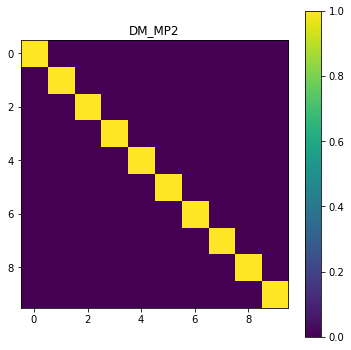

In [20]:
hf_h2_1dm = hf_h2.make_rdm1()
S = h2.intor("int1e_ovlp")
S_transformed = mo_coeff.T @ S @ mo_coeff
fig_h2 = plt.figure(figsize=(6, 6))
ax_h2 = fig_h2.add_subplot(111)
ax_h2.set_title('DM_MP2')
image_h2 = ax_h2.imshow(S_transformed)
plt.colorbar(image_h2)

E(MP2) = -1.01244593590222  E_corr = -0.0233302509003011
E(SCS-MP2) = -1.01711198608229  E_corr = -0.0279963010803613


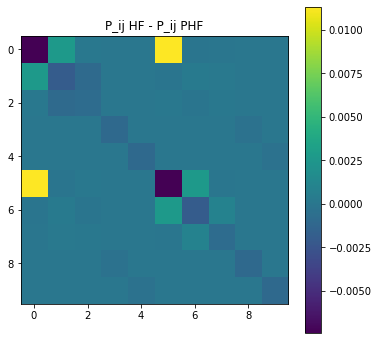

In [21]:
h2_mp2 = mp.MP2(hf_h2).run()
h2_mp2_1dm = h2_mp2.make_rdm1(ao_repr=False)
h2_mp2_1dm = mo_coeff @ h2_mp2_1dm @ mo_coeff.T
fig_h2 = plt.figure(figsize=(6, 6))
ax_h2 = fig_h2.add_subplot(111)
ax_h2.set_title('P_ij HF - P_ij PHF')
image_h2 = ax_h2.imshow(hf_h2_1dm - h2_mp2_1dm)
plt.colorbar(image_h2)

**Plotting electron density for H2O**

In [35]:
ticks = 30
lane = np.linspace(-0.8, 0.8, ticks)
x_center = 0
y_center = 0
xyz_points = np.array([[x + x_center, y + y_center, 0] for x in lane for y in lane])


def density_matrix_pointwise(coords, mol, dm, return_type="dm"):
    ao_vals = np.array(mol.eval_ao("GTOval_sph", coords))
    n_coords = len(coords)
    n_orbitals = ao_vals.shape[-1]
    ao_vals = ao_vals.reshape(n_coords, 1, n_orbitals)
    #ao_vals_pointwise = np.matmul(ao_vals_dagger, ao_vals)
    #ao_vals_pointwise = [[coords[i].tolist(), ao_vals_pointwise[i].tolist()] for i in range(n_coords)]
    if return_type == "ao_vals":
        return ao_vals
    elif return_type == "density":
        res = []
        for i in range(len(coords)):
            [x, y, _] = coords[i]
            ao_vals_for_point = ao_vals[i].flatten()
            z = np.einsum("ij,i,j", dm, ao_vals_for_point, ao_vals_for_point)
            res.append([x, y, z])
        res = np.array(res)
        return res
    return ao_vals

dm = hf_h2_1dm
density_pointwise = density_matrix_pointwise(xyz_points, h2, dm, "density")
X = density_pointwise[:, 0]
Y = density_pointwise[:, 1]
Z = density_pointwise[:, 2]
X = X.reshape(ticks, ticks)
Y = Y.reshape(ticks, ticks)
Z = Z.reshape(ticks, ticks)

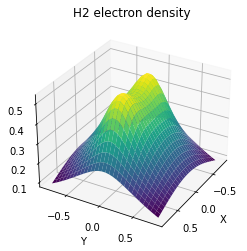

In [36]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap="viridis")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('ρ')
ax.set_title('H2 electron density')
ax.view_init(30, 30)
plt.show()

In [ ]:
ticks = 30
coords = [[x, y, 0] for x in range(ticks) for y in range(ticks)]

In [ ]:
cutoff = 5
dist_matrix = cdist(coords, coords)
idx = np.arange(len(coords))
neighbour_coords = (dist_matrix < cutoff) * idx[np.newaxis, :]

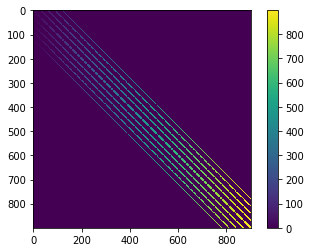

In [ ]:
plt.imshow(neighbour_coords, cmap='viridis', interpolation='nearest')

# Add colorbar for reference (optional)
plt.colorbar()

# Show the plot
plt.show()

**Testing the speed of Orbital evaluation**

In [29]:
def run_orbital_eval(coords):
    start_timestamp = datetime.now()
    h2 = gto.M(atom='H 0 2 0; H 2 0 0', basis='ccpvdz', unit='B')
    #h2.atom = [['H', (0, 2, 0)], ['H', (2, 0, 0)]]
    #h2.basis = 'ccpvdz'
    #h2.unit = 'B'
    #h2.build()
    building_timestamp = datetime.now()

    building_time = building_timestamp - start_timestamp
    ao_vals_np = np.array(h2.eval_ao("GTOval_sph", coords))
    ao_vals_np_timestamp = datetime.now()
    ao_vals_np_time = ao_vals_np_timestamp - building_timestamp

    ao_vals = h2.eval_ao("GTOval_sph", coords)
    ao_vals_timestamp = datetime.now()
    ao_vals_time = ao_vals_timestamp - ao_vals_np_timestamp
    print(f"Building time:{building_time}")
    print(f"AO eval time without conversion: {ao_vals_time}, relative: building: {building_time / (building_time + ao_vals_time)}, AO eval: {(ao_vals_time / (building_time + ao_vals_time))}")
    print(f"AO eval time with conversion: {ao_vals_np_time}, relative: building: {building_time / (building_time + ao_vals_np_time)}, AO eval: {(ao_vals_np_time / (building_time + ao_vals_np_time))}")



In [31]:
run_orbital_eval(xyz_points)

Building time:0:00:00.200677
AO eval time without conversion: 0:00:00.047975, relative: building: 0.8070596657175491, AO eval: 0.19294033428245097
AO eval time with conversion: 0:00:00.019554, relative: building: 0.9112114098378521, AO eval: 0.08878859016214792


In [ ]:
import pickle
import numpy as np

In [ ]:
file = np.load("../../logging/20230810_105113_densnet_Th1ZgPjP_md_h2.npz_densities_final/best/best_loss.npz", allow_pickle=True)

In [ ]:
for key in list(file.keys()):
    print(key)
    print(file[key])

loss_val
0.03242198005318642
mean_mae_val
0.03242198005318642
mean_log_mae_val
-3.4289186000823975
densities_val
0.03242198005318642
step
3000
